# A/B-тест пользовательского поведения в мобильной игре

**Описание:** Cookie Cats - игра-головоломка от студии Tactile Entertainment в жанре "три-в-ряд". После прохождения определенного уровня игроку предлагается подождать некоторое время либо совершить внутриигровую покупку для продолжения игры. Сейчас такой выбор предстает перед игроком на 30-м уровне.

**Задача:** Как изменится поведение новых пользователей в течение 7 дней после скачивания игры, если сдвинуть этот выбор на 40 уровень?

**Вывод:** Не рекомендую раскатывать изменение на всех пользователей. В ходе эксперимента был зафиксирован не значимый рост среднего количества сыгранных раундов, однако ретеншн в течение 1 дня после скачивания упал (не стат. значимо), а ретеншн через 7 дней после скачивание упал ощутимо (стат. значимо).

В сборе данных грубые ошибки, для будущих подобных АБ-тестов необходимо как минимум собирать информацию о количестве пройденных уровней.

## Импортируем библиотеки

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

## Исследуем данные

In [76]:
df = pd.read_csv('cookie_cats.csv')

**userid:** A unique number that identifies each player.

**version:** Test group.

**sum_gamerounds:** The number of game rounds played by the player during the first 14 days after install.

**retention_1:** Did the player come back and play 1 day after installing?

**retention_7:** Did the player come back and play 7 days after installing?

In [77]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [78]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


У колонки version смешанный тип данных, сразу проверим какие там значения.

In [86]:
df['version'].value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

Все в порядке.

In [89]:
df['userid'].nunique() == df['userid'].count()

True

In [84]:
df.drop_duplicates().size == df.size

True

Итак, пропущенных значений и дубликатов нет.

А это интересный список пользователей, которые возвращались в игру, играли в нее, но так и не прошли ни одного уровня.

In [136]:
df[((df['sum_gamerounds'] == 0) & (df['retention_1'] == True))
   | ((df['sum_gamerounds'] == 0) & (df['retention_7'] == True))]

,userid,version,sum_gamerounds,retention_1,retention_7
1000,110479,gate_30,0,False,True
1872,203165,gate_30,0,True,False
2330,257330,gate_30,0,True,False
2803,307703,gate_40,0,True,True
3994,442819,gate_30,0,True,False
...,...,...,...,...,...
86779,9616345,gate_40,0,True,False
87635,9708844,gate_30,0,True,False
87973,9750017,gate_40,0,True,False
88671,9830174,gate_40,0,True,False


А это список людей, которые вернулись в игрутолько через несколько дней после установки.

In [342]:
long_retention = df[(df['retention_1'] == False) & (df['retention_7'] == True)]
long_retention

,userid,version,sum_gamerounds,retention_1,retention_7
10,1842,gate_40,3,False,True
23,2729,gate_30,105,False,True
90,8788,gate_30,19,False,True
102,10200,gate_40,106,False,True
143,13429,gate_30,60,False,True
...,...,...,...,...,...
89967,9975174,gate_30,26,False,True
90044,9982773,gate_30,1,False,True
90046,9983040,gate_30,137,False,True
90156,9996093,gate_40,23,False,True


In [343]:
long_retention.groupby('version').agg({'userid': ['count', 'nunique'],
                          'sum_gamerounds': ['mean', 'median', 'std', 'sum', 'min', 'max'],
                            'retention_1': 'mean',
                               'retention_7': 'mean'})

userid         sum_gamerounds                                         \
         count nunique           mean median          std     sum min    max   
version                                                                        
gate_30   1826    1826     100.431544   43.0  1168.683901  183388   0  49854   
gate_40   1773    1773      75.261139   47.0    94.478048  133438   0   1241   

        retention_1 retention_7  
               mean        mean  
version                          
gate_30         0.0         1.0  
gate_40         0.0         1.0

## Изучим тестовые группы

**gate_30** - контрольная группа

**gate_40** - тестовая группа

In [93]:
df['version'].value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [90]:
df['version'].value_counts(normalize=True)

gate_40    0.504374
gate_30    0.495626
Name: version, dtype: float64

Выборки практически одинаковые по размеру.

Теперь посмотрим на сводку по каждой группе:

In [109]:
df.groupby('version').agg({'userid': ['count', 'nunique'],
                          'sum_gamerounds': ['mean', 'median', 'std', 'sum', 'min', 'max'],
                            'retention_1': 'mean',
                               'retention_7': 'mean'})

userid         sum_gamerounds                                         \
         count nunique           mean median         std      sum min    max   
version                                                                        
gate_30  44700   44700      52.456264   17.0  256.716423  2344795   0  49854   
gate_40  45489   45489      51.298776   16.0  103.294416  2333530   0   2640   

        retention_1 retention_7  
               mean        mean  
version                          
gate_30    0.448188    0.190201  
gate_40    0.442283    0.182000

Никто из пользователей не попал сразу в обе группы. У контрольной группы показатели чуть выше, а стандартное отклонение вообще намного больше. Судя по максимальному значению по пройденным уровням, в контрольной группе присутствуют явно выраженные выбросы. Их мы изучим позже.

**К сожалению, данные собраны плохо. Не хватает важной метрики: количества пройденных уровней для каждого игрока. Наличие этой метрики помогло бы так сильно не исказить выводы об истинной причине оттока пользвателей. Также мы могли бы наверняка знать, какие пользователи даже не дошли до "gate" уровня (в котором мы предлагаем подождать или совершить покупку).**

Поскольку мы наверняка не знаем какие уровни именно учтены в **sum_gamerounds** и сколько раз они там повторяются, мы уберем из эксперимента тех, у кого эта метрика **меньше 30** в контрольной группе, и у кого **меньше 40** в тестовой группе.


Я сделаю следующее:

1) Отделю от общего списка тех игроков, которые даже не дошли до 30 уровня (т.е. как минимум те, у кого метрика **sum_gamerounds** < 30: *они точно не видели нашего предложения подождать или совершить покупку, поэтому большой разницы между ними быть не должно. Если она есть, мы можем убедиться в неоднородности изначальных данных*;

2) Уберу из данных всех, кто не видел нашего предложения вовсе (т.е. не дошел до нужного уровня), и сравню уже реальный эффект от нашего эксперимента: *таким образом в наших данных останется минимальное количество людей, которые так и не увидели "gate" уровень, убрать их всех с имеющимся набором данных не получится*.

## Проверка гомогенности выборок

Созданим датафрейм с пользователями, которые точно не дошли до 30 уровня.

In [182]:
under30 = df[df['sum_gamerounds'] < 30]
under30

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
3,483,gate_40,1,False,False
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
10,1842,gate_40,3,False,True
...,...,...,...,...,...
90181,9998733,gate_40,10,True,False
90182,9999178,gate_30,21,True,False
90183,9999349,gate_30,10,False,False
90186,9999710,gate_30,28,True,False


In [119]:
under30.groupby('version').agg({'userid': ['count', 'nunique'],
                          'sum_gamerounds': ['mean', 'median', 'std', 'sum', 'min', 'max'],
                            'retention_1': 'mean',
                               'retention_7': 'mean'})

userid         sum_gamerounds                                  \
         count nunique           mean median      std     sum min max   
version                                                                 
gate_30  28044   28044       9.324205    7.0  8.00230  261488   0  29   
gate_40  28876   28876       9.203768    7.0  7.95069  265768   0  29   

        retention_1 retention_7  
               mean        mean  
version                          
gate_30    0.238661    0.042576  
gate_40    0.235420    0.039306

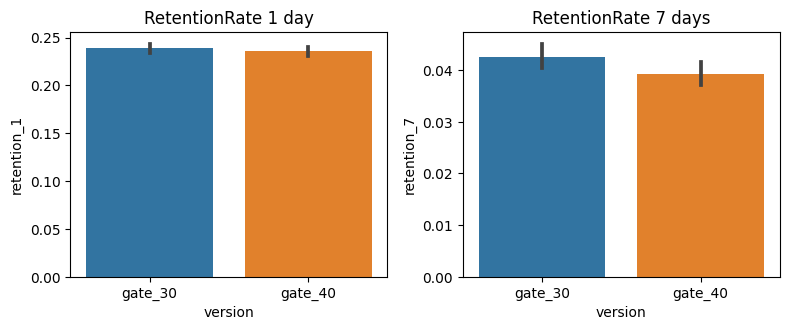

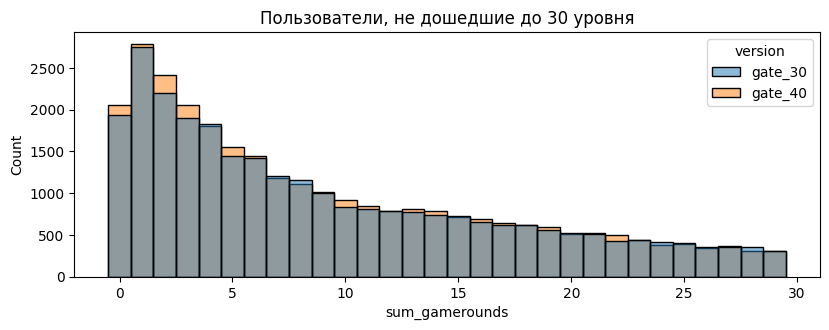

In [180]:
plt.figure(figsize=(8, 6), layout='tight')
plt.subplot(2, 2, 1)
sns.barplot(under30, x='version', y='retention_1')
plt.title('RetentionRate 1 day')

plt.subplot(2, 2, 2)
sns.barplot(under30, x='version', y='retention_7')
plt.title('RetentionRate 7 days')

plt.figure(figsize=(16, 6), layout='tight')
plt.subplot(2, 2, 3)
sns.histplot(under30, x='sum_gamerounds', hue='version', discrete=True)
plt.title('Пользователи, не дошедшие до 30 уровня');

Напоминаю, что мы проверяем гомогенность даннных на примере пользователей, которые не видели разные версии игры (sum_gamerounds < 30).

**H0:** Средняя sum_gamerounds (gate_30) = Средняя sum_gamerounds (gate_40)

**H1:** Средняя sum_gamerounds (gate_30) != Средняя sum_gamerounds (gate_40)

Распределение явно не нормальное, но для формальности проведем тест Шапиро-Уилка.

In [187]:
_, pval = stats.shapiro(under30['sum_gamerounds'])
pval, pval < 0.05

(0.0, True)

Я буду использовать U-тест Манна-Уитни.

In [221]:
under30_rounds_control = under30[under30['version'] == 'gate_30']['sum_gamerounds']
under30_rounds_test = under30[under30['version'] == 'gate_40']['sum_gamerounds']

_, pval = stats.mannwhitneyu(under30_rounds_control, under30_rounds_test)
pval, pval < 0.05

(0.0728013178603117, False)

Мы не отклоняем H0. Значимой разницы в количестве пройденных уровней не обнаружено.

Для полноты картины сравним еще разницу в ретеншенах.

**H0:** retention_1 (gate_30) = retention_1 (gate_40)

**H1:** retention_1 (gate_30) != retention_1 (gate_40)

In [226]:
under30_retention1_control = under30[under30['version'] == 'gate_30']['retention_1'].sum()
under30_retention1_test = under30[under30['version'] == 'gate_40']['retention_1'].sum()

under30_control = len(under30[under30['version'] == 'gate_30'])
under30_test = len(under30[under30['version'] == 'gate_40'])

_, pval = proportions_ztest([under30_retention1_control, under30_retention1_test],
                 [under30_control, under30_test])
pval, pval < 0.05

(0.3634333964640146, False)

Мы не отклоняем H0. Значимой разницы в **retention_1** не обнаружено.

**H0:** retention_7 (gate_30) = retention_7 (gate_40)

**H1:** retention_7 (gate_30) != retention_7 (gate_40)

In [227]:
under30_retention7_control = under30[under30['version'] == 'gate_30']['retention_7'].sum()
under30_retention7_test = under30[under30['version'] == 'gate_40']['retention_7'].sum()

_, pval = proportions_ztest([under30_retention7_control, under30_retention7_test],
                 [under30_control, under30_test])
pval, pval < 0.05

(0.04896787766058105, True)

Мы отклоняем H0. Значимая разница в **retention_7** обнаружена.

p-value = 0.049, что ставит значимость такой разницы под сомнение.

Думаю, что в результате трех этих тестов можно считать данные действительно случайно распределенными и однородными.

## Анализ эффективности фичи

Теперь избавимся от пользователей, которые точно не прошли "gate"-уровень.

In [241]:
updated_df = df[((df['version'] == 'gate_30') & (df['sum_gamerounds'] >= 30)) |
  ((df['version'] == 'gate_40') & (df['sum_gamerounds'] >= 40))]
updated_df

,userid,version,sum_gamerounds,retention_1,retention_7
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
8,1574,gate_40,108,True,True
...,...,...,...,...,...
90171,9997757,gate_30,84,True,False
90175,9998125,gate_30,30,False,False
90177,9998376,gate_40,53,False,False
90184,9999441,gate_40,97,True,False


In [340]:
updated_df.groupby('version').agg({'userid': ['count', 'nunique'],
                          'sum_gamerounds': ['mean', 'median', 'std', 'sum', 'min', 'max'],
                            'retention_1': 'mean',
                               'retention_7': 'mean'})

userid         sum_gamerounds                                        \
         count nunique           mean median         std      sum min   max   
version                                                                       
gate_30  13565   13565     142.048802   90.0  149.150827  1926892  40  2961   
gate_40  13827   13827     142.667824   92.0  151.198353  1972668  40  2640   

        retention_1 retention_7  
               mean        mean  
version                          
gate_30    0.837670    0.502838  
gate_40    0.830187    0.485065

Сводные данные сильно изменились в пользу тестовой группы, а выборки уже не такие равные. К сожалению, мы не можем убрать из контрольной группы всех игроков с **sum_gamerounds** < 40, потому что есть риск убрать тех, кто прошел "gate"-уровень.

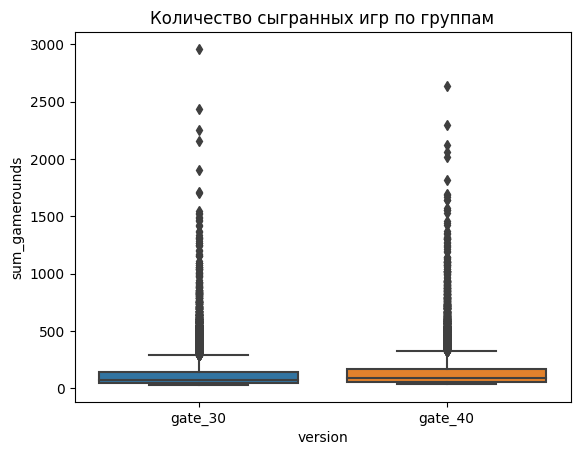

In [245]:
sns.boxplot(updated_df, x='version', y='sum_gamerounds')
plt.title('Количество сыгранных игр по группам');

Посмотрим на этот выброс.

In [242]:
updated_df[updated_df['sum_gamerounds'] > 10000]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


Даже если тратить на один уровень 30 секунд и играть круглосуточно без остановки, то для того, чтобы сыграть 49854 раунда, необходимо более 17 суток. Уберем этот выброс.

In [243]:
updated_df = updated_df[updated_df['sum_gamerounds'] < 10000]

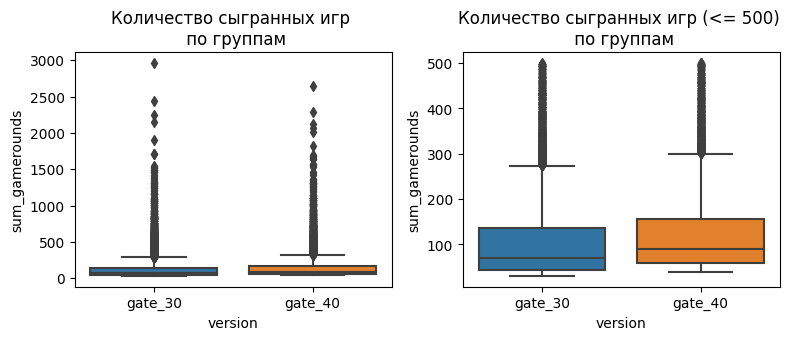

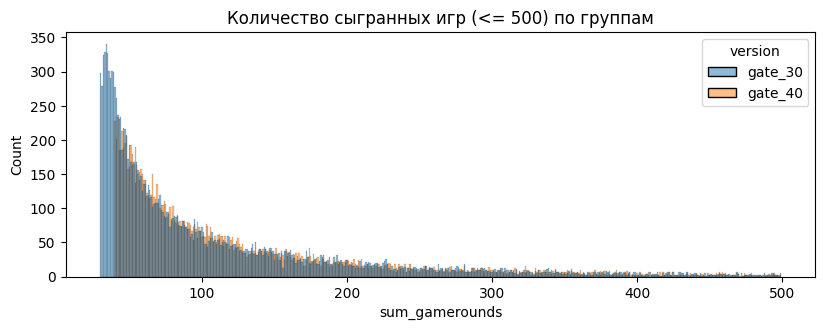

In [314]:
plt.figure(figsize=(8, 6), layout='tight')

plt.subplot(2, 2, 1)
sns.boxplot(updated_df, x='version', y='sum_gamerounds')
plt.title('Количество сыгранных игр \n по группам')

plt.subplot(2, 2, 2)
sns.boxplot(updated_df[updated_df['sum_gamerounds'] <= 500], x='version', y='sum_gamerounds')
plt.title('Количество сыгранных игр (<= 500) \n по группам')

plt.figure(figsize=(16, 6), layout='tight')
plt.subplot(2, 2, 3)
sns.histplot(updated_df[updated_df['sum_gamerounds'] < 500],
             x='sum_gamerounds', hue='version', discrete=True)
plt.title('Количество сыгранных игр (<= 500) по группам')

plt.show()

На первом боксплоте почти не видно разницы между группами, поэтому я нарисовал второй с меньшим числом вбросов, однако от выбросов мы не можем избавиться, потому что 3000 минутных игр за неделю - вполне реальная цифра.

По гистограмме мы еще раз убеждаемся в том, как плохо собраны данные. Брать в учет 30 <= **sum_gamerounds** < 40 для контрольной группы будет ошибкой, это слишком сильно сместит нашу оценку. Путем наименьших жертв мы пожертвуем частью пользователей из котнрольной группы, которее, вероятно, прошли "gate"-уровень.

Продолжим анализ, убрав их.

In [330]:
above40 = updated_df[updated_df['sum_gamerounds'] > 39].sort_values(by='version')

In [331]:
above40.groupby('version').agg({'userid': ['count', 'nunique'],
                          'sum_gamerounds': ['mean', 'median', 'std', 'sum', 'min', 'max'],
                            'retention_1': 'mean',
                               'retention_7': 'mean'})

userid         sum_gamerounds                                        \
         count nunique           mean median         std      sum min   max   
version                                                                       
gate_30  13565   13565     142.048802   90.0  149.150827  1926892  40  2961   
gate_40  13827   13827     142.667824   92.0  151.198353  1972668  40  2640   

        retention_1 retention_7  
               mean        mean  
version                          
gate_30    0.837670    0.502838  
gate_40    0.830187    0.485065

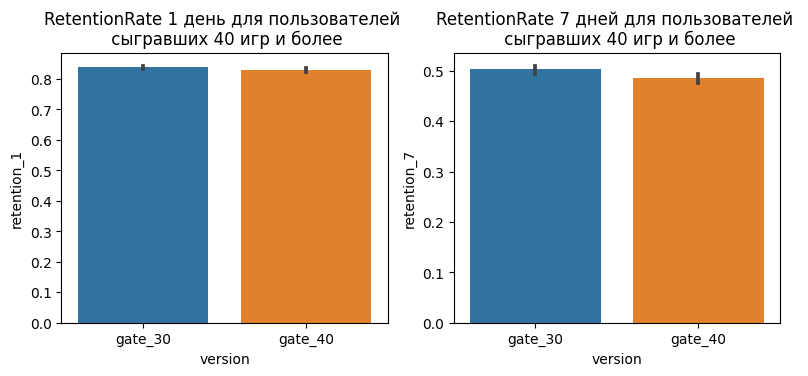

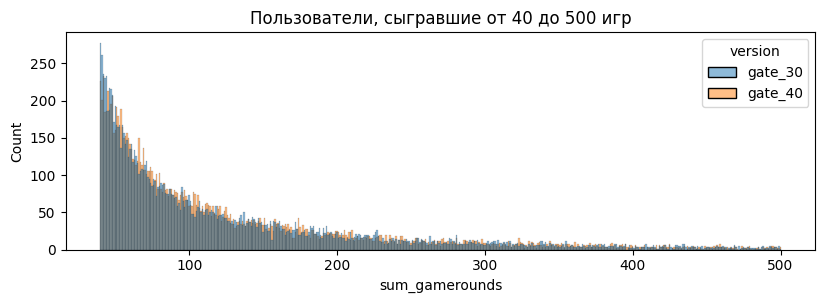

In [334]:
plt.figure(figsize=(8, 10), layout='tight')
plt.subplot(3, 2, 1)
sns.barplot(above40, x='version', y='retention_1')
plt.title('RetentionRate 1 день для пользователей \n сыгравших 40 игр и более')

plt.subplot(3, 2, 2)
sns.barplot(above40, x='version', y='retention_7')
plt.title('RetentionRate 7 дней для пользователей \n сыгравших 40 игр и более')

plt.figure(figsize=(16, 8), layout='tight')
plt.subplot(3, 2, 5)
sns.histplot(above40[above40['sum_gamerounds'] <= 500], x='sum_gamerounds', hue='version', discrete=True)
plt.title('Пользователи, сыгравшие от 40 до 500 игр');

Приступим к тестам, для начала как всегда проверим из нормального ли распределения пришли данные (это вряд ли).

**H0:** Средняя sum_gamerounds (gate_30) = Средняя sum_gamerounds (gate_40)

**H1:** Средняя sum_gamerounds (gate_30) != Средняя sum_gamerounds (gate_40)

In [336]:
_, pval = stats.shapiro(above40['sum_gamerounds'])
pval, pval < 0.05

(0.0, True)

Отклоняем H0, распределение не нормальное.

Я буду снова использовать U-тест Манна-Уитни.

In [337]:
above40_rounds_control = above40[above40['version'] == 'gate_30']['sum_gamerounds']
above40_rounds_test = above40[above40['version'] == 'gate_40']['sum_gamerounds']

_, pval = stats.mannwhitneyu(above40_rounds_control, above40_rounds_test)
pval, pval < 0.05

(0.05758122336308788, False)

Мы не отклоняем H0. Значимой разницы в количестве пройденных уровней не обнаружено.

Теперь сравним еще разницу в ретеншенах.

**H0:** retention_1 (gate_30) = retention_1 (gate_40)

**H1:** retention_1 (gate_30) != retention_1 (gate_40)

In [338]:
above40_retention1_control = above40[above40['version'] == 'gate_30']['retention_1'].sum()
above40_retention1_test = above40[above40['version'] == 'gate_40']['retention_1'].sum()

above40_control = len(above40[above40['version'] == 'gate_30'])
above40_test = len(above40[above40['version'] == 'gate_40'])

_, pval = proportions_ztest([above40_retention1_control, above40_retention1_test],
                 [above40_control, above40_test])
pval, pval < 0.05

(0.09615474103646639, False)

Мы не отклоняем H0. Значимой разницы в **retention_1** не обнаружено.

**H0:** retention_7 (gate_30) = retention_7 (gate_40)

**H1:** retention_7 (gate_30) != retention_7 (gate_40)

In [339]:
above40_retention7_control = above40[above40['version'] == 'gate_30']['retention_7'].sum()
above40_retention7_test = above40[above40['version'] == 'gate_40']['retention_7'].sum()

_, pval = proportions_ztest([above40_retention7_control, above40_retention7_test],
                 [above40_control, above40_test])
pval, pval < 0.05

(0.0032655478429167635, True)

Мы отклоняем H0. Значимая разница в **retention_7** обнаружена.

## Заключение

В нашем эксперименте мы увидели, что пользователи тестовой группы в среднем стали чуть больше играть (не стат. значимо), однако **retention** в течение первых 24 часов после скачивания немного упал (не стат. значимо), а **retention** через неделю после скачивания упал ощутимо (стат. значимо).

Неизвестно, как это изменение могло бы повлиять на прибыль, поэтому отталкиваясь от показателя возвращаемости пользователей, я не рекомендую раскатывать эту фичу.